# 基于Informer的动量轮FMW2轴温长序列预测与健康预警

## 下载数据

In [1]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

'git' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'git' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [2]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [3]:
# !pip install -r ./Informer2020/requirements.txt

## 训练与测试

### 导入库函数

In [4]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

d:\ProgramData\Anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 创建Argparse

In [5]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]
# args.data = 'ETTh1' # data
args.data = 'beartem0529' # data
args.root_path = './data/ETT' # root path of data file
args.data_path = 'data_align_tpt_0206gbk_final.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = '动量轮FMW2轴承温度' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.train_time_range = ['2015-08-01 01:00:00','2016-07-31 00:00:00'] # 训练时间范围
args.valid_time_range = ['2016-04-19 00:00:00','2016-05-19 00:00:00'] # 验证时间范围
args.test_time_range = ['2015-08-05 01:00:00','2016-07-31 00:00:00'] # 测试时间范围

args.train_time_range = ['2015-08-01 01:00:00','2016-05-24 00:00:00'] # 训练时间范围
args.valid_time_range = ['2016-04-19 00:00:00','2016-05-19 00:00:00'] # 验证时间范围
args.test_time_range = ['2015-08-05 01:00:00','2016-05-31 00:00:00'] # 测试时间范围

args.train_time_range = ['2015-08-01 01:00:00','2016-05-19 00:00:00'] # 训练时间范围
args.valid_time_range = ['2016-04-19 00:00:00','2016-05-19 00:00:00'] # 验证时间范围
args.test_time_range = ['2015-08-05 01:00:00','2016-05-31 00:00:00'] # 测试时间范围

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 11 # encoder input size
args.dec_in = 11 # decoder input size
args.c_out = 11 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.s_layers = '3,2,1' # num of encoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.inverse = True
args.des = 'train'
args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1' # 'type1','type2'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 20
args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0'


### cuda调用

In [6]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

### 任务指定

In [7]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'beartem0529':{'data':'data_tpt_0206gbk_final_toplist.csv','T':'动量轮FMW2轴承温度','M':[11,11,11],'S':[1,1,1],'MS':[11,11,1]}
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [8]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [9]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'beartem0529', 'root_path': './data/ETT', 'data_path': 'data_tpt_0206gbk_final_toplist.csv', 'features': 'M', 'target': '动量轮FMW2轴承温度', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'train_time_range': ['2015-08-01 01:00:00', '2016-05-19 00:00:00'], 'valid_time_range': ['2016-04-19 00:00:00', '2016-05-19 00:00:00'], 'test_time_range': ['2015-08-05 01:00:00', '2016-05-31 00:00:00'], 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 11, 'dec_in': 11, 'c_out': 11, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 's_layers': '3,2,1', 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'inverse': True, 'des': 'train', 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 20, 'use_gpu': True, 'gpu': 0, '

### 调用Informer函数

In [10]:
Exp = Exp_Informer

### 网络训练

In [11]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_beartem0529_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_train_0>>>>>>>>>>>>>>>>>>>>>>>>>>
	iters: 100, epoch: 1 | loss: 1.6690912
	speed: 0.1426s/iter; left time: 169.8135s
	iters: 200, epoch: 1 | loss: 1.3621461
	speed: 0.1266s/iter; left time: 138.1564s
Epoch: 1 cost time: 28.904689073562622
Epoch: 1, Steps: 215 | Train Loss: 1.7494513 Vali Loss: 2.4048641 Test Loss: 1.3011162
Validation loss decreased (inf --> 2.404864).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.8893250
	speed: 0.2407s/iter; left time: 234.9416s
	iters: 200, epoch: 2 | loss: 1.2290113
	speed: 0.1074s/iter; left time: 94.0718s
Epoch: 2 cost time: 23.056216955184937
Epoch: 2, Steps: 215 | Train Loss: 0.9518339 Vali Loss: 1.9801321 Test Loss: 1.1144248
Validation loss decreased (2.404864 --> 1.980132).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.7590327
	speed:

### 测试集预测结果

In [12]:
# 时间索引

df_time = pd.read_csv(os.path.join(args.root_path,args.data_path),encoding='gbk')
df_time = pd.to_datetime(df_time['date'], format='%Y-%m-%d %H:%M:%S').to_list()
train_time_range = args.train_time_range # 训练时间范围
valid_time_range = args.valid_time_range # 验证时间范围
test_time_range = args.test_time_range # 测试时间范围

border1s = [df_time.index(pd.to_datetime(train_time_range[0])), df_time.index(pd.to_datetime(valid_time_range[0])) - args.seq_len, df_time.index(pd.to_datetime(test_time_range[0])) + args.pred_len]
# 训练集、验证集、测试集开始时间
border2s = [df_time.index(pd.to_datetime(train_time_range[1])), df_time.index(pd.to_datetime(valid_time_range[1])), df_time.index(pd.to_datetime(test_time_range[1]))]
# 训练集、验证集、测试集结束时间

(7168, 24, 11) (7168, 24, 11)


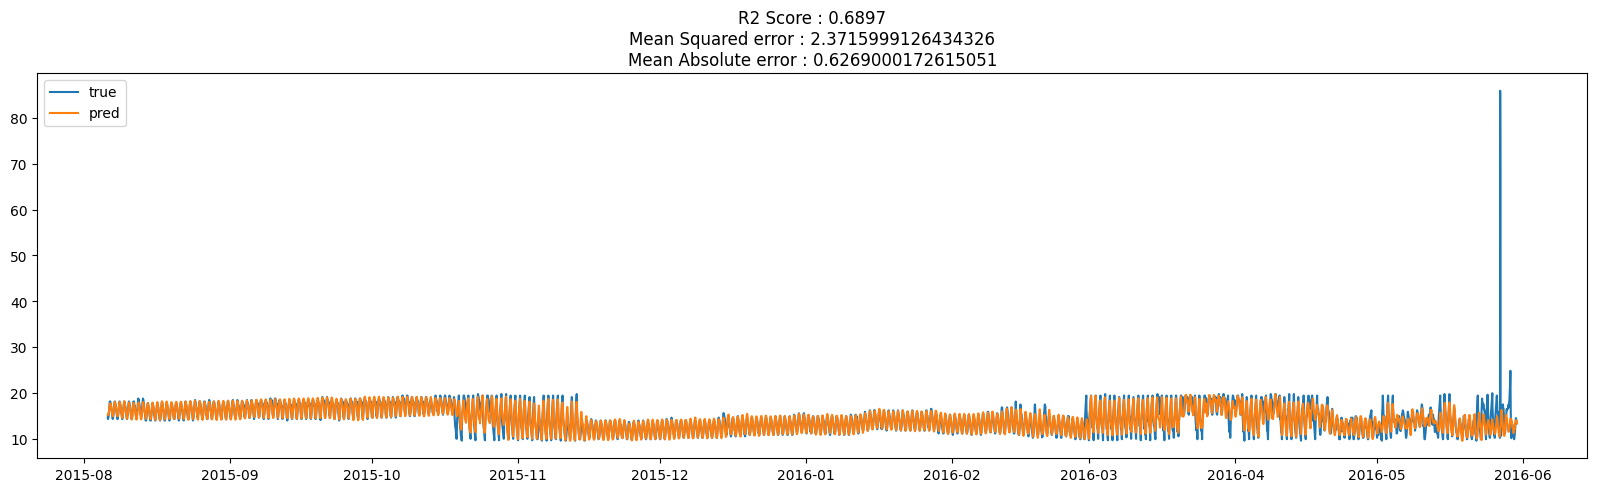

In [13]:
# 测试结果
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')
print(preds.shape,trues.shape)

test_time_show = df_time[border1s[2]:border1s[2]+preds.shape[0]]
df_show = pd.DataFrame(preds[:,-1,0],columns=['pred'],index=pd.DatetimeIndex(test_time_show))
df_show['true'] = trues[:,-1,0]
df_show['error'] = trues[:,-1,0]-preds[:,-1,0]
plt.figure(figsize=(20,5))
# plt.plot(trues[:,-1,0], label='GroundTruth')
# plt.plot(preds[:,-1,0], label='Prediction')
plt.plot(df_show[['true','pred']])
plt.legend(['true','pred'])
r2=np.round(r2_score(df_show['true'],df_show['pred']),4)
mse=np.round(mean_squared_error(df_show['true'],df_show['pred']),4)
mae=np.round(mean_absolute_error(df_show['true'],df_show['pred']),4)
plt.title('R2 Score : {}'.format(r2)+'\n'+'Mean Squared error : {}'.format(mse)+'\n'+'Mean Absolute error : {}'.format(mae))
plt.show()

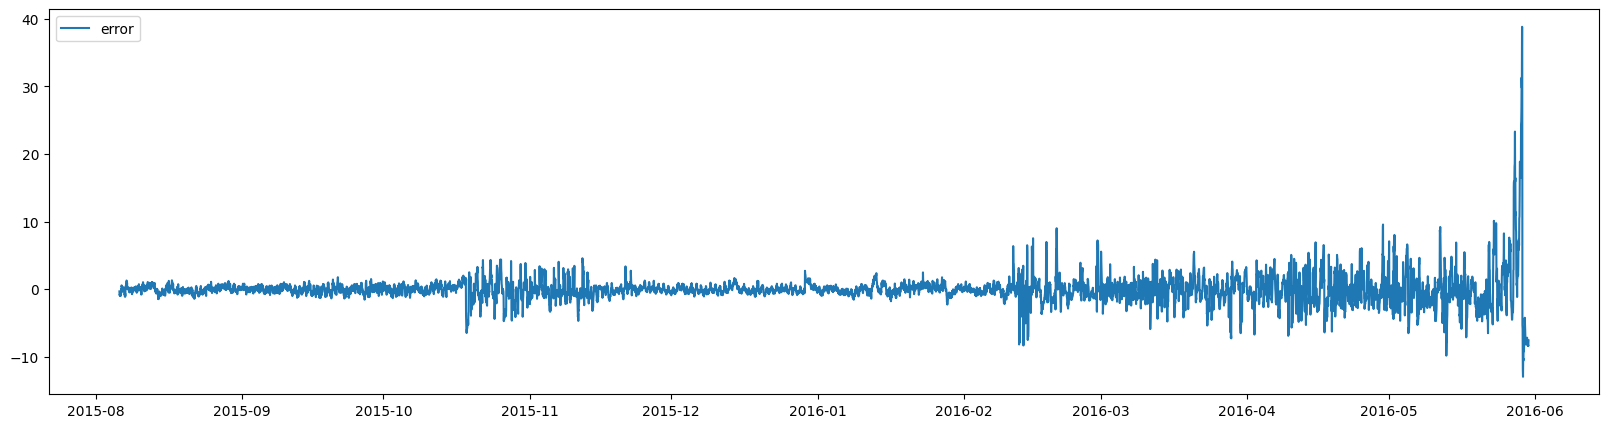

In [14]:
# 误差曲线
plt.figure(figsize=(20,5))
plt.plot(df_show[['error']])
plt.legend(['error'])

### 分段预测评估

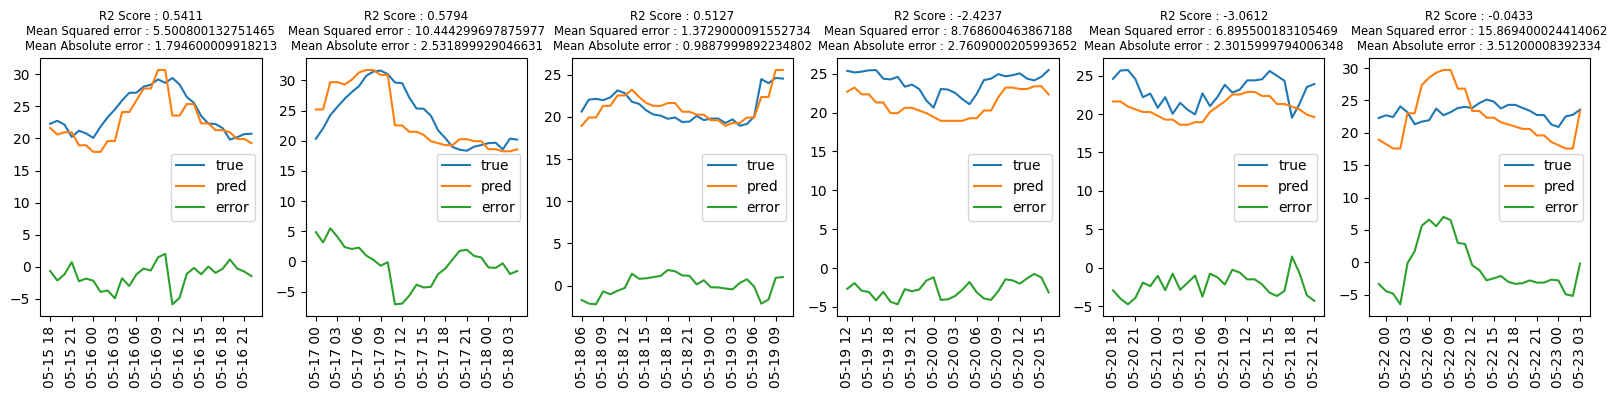

In [28]:
# 分节评估
plotsize = 240
row = 40
plt.figure(figsize=(20,20*8))
for i in range(228,234):
    plotindex = [int(i/plotsize*len(df_show)),int((i+1)/plotsize*len(df_show))-1]
    plt.subplot(row,int(plotsize/row),i+1)
    df_show_sub = df_show[(df_show.index>=df_show.index[plotindex[0]]) & (df_show.index<df_show.index[plotindex[1]])]
    # plt.plot(df_show_sub[['true','pred']])
    plt.plot(df_show_sub)
    plt.legend(['true','pred','error'])
    r2=np.round(r2_score(df_show_sub['true'],df_show_sub['pred']),4)
    mse=np.round(mean_squared_error(df_show_sub['true'],df_show_sub['pred']),4)
    mae=np.round(mean_absolute_error(df_show_sub['true'],df_show_sub['pred']),4)
    plt.title('R2 Score : {}'.format(r2)+'\n'+'Mean Squared error : {}'.format(mse)+'\n'+'Mean Absolute error : {}'.format(mae),fontsize='small')
    plt.xticks(rotation = 90)
plt.show()

In [29]:
df_show.to_csv('./informer.csv')

(array([16948. , 16948.5, 16949. , 16949.5, 16950. , 16950.5, 16951. ,
        16951.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

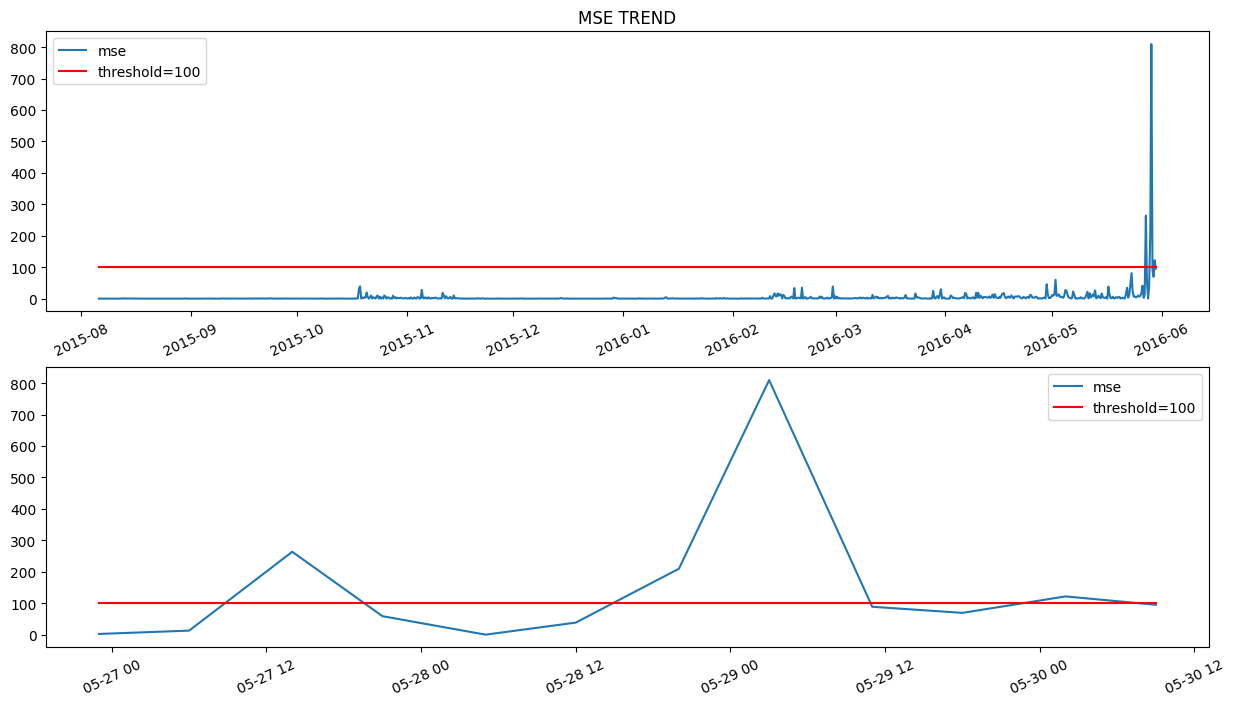

In [16]:
# mse曲线
plotsize = 960
mselist = []
time_mse_list = []
threshold=100
for i in range(0,plotsize):
    plotindex = [int(i/plotsize*len(df_show)),int((i+1)/plotsize*len(df_show))-1]
    df_show_sub = df_show[(df_show.index>=df_show.index[plotindex[0]]) & (df_show.index<df_show.index[plotindex[1]])]
    r2=np.round(r2_score(df_show_sub['true'],df_show_sub['pred']),4)
    mse=np.round(mean_squared_error(df_show_sub['true'],df_show_sub['pred']),4)
    mae=np.round(mean_absolute_error(df_show_sub['true'],df_show_sub['pred']),4)
    time_mse_list.append(df_show.index[plotindex[0]])
    mselist.append(mse)
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.title('MSE TREND')
plt.plot(time_mse_list,mselist)
plt.plot([time_mse_list[0],time_mse_list[-1]],[threshold,threshold],'r-')
plt.legend(['mse','threshold='+str(threshold)])
plt.xticks(rotation = 25)
plt.subplot(2,1,2)
plt.plot(time_mse_list[-12::],mselist[-12::])
plt.plot([time_mse_list[-12],time_mse_list[-1]],[threshold,threshold],'r-')
plt.legend(['mse','threshold='+str(threshold)])
plt.xticks(rotation = 25)


(array([16948. , 16948.5, 16949. , 16949.5, 16950. , 16950.5, 16951. ,
        16951.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

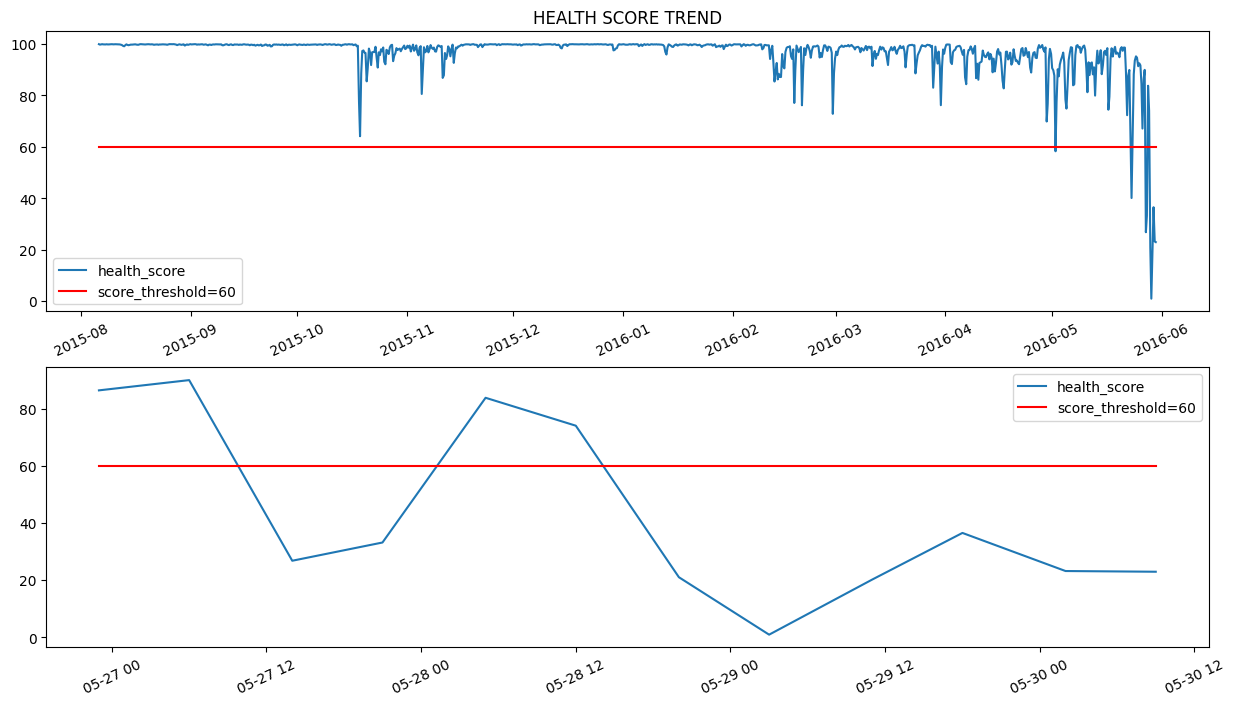

In [17]:
# 健康评分函数
import math
# 加权平均
def weighted_mean(list,alpha=0.3):
    mean_list = []
    for i in range(len(list)):
        if i==0:
            mean_list.append(list[i])
        if i>0:
            mean_list.append(list[i]*(1-alpha)+list[i-1]*alpha)
    return mean_list
# 健康分数
def health_score(mselist,k=0.01):
    score_list = []
    for mse in mselist:
        score = 100-100*(math.tanh(k*mse))
        score_list.append(score)
    return score_list

# 健康评分曲线
plotsize = 960
mselist = []
r2list = []
time_mse_list = []
threshold=60
for i in range(0,plotsize):
    plotindex = [int(i/plotsize*len(df_show)),int((i+1)/plotsize*len(df_show))-1]
    df_show_sub = df_show[(df_show.index>=df_show.index[plotindex[0]]) & (df_show.index<df_show.index[plotindex[1]])]
    r2=np.round(r2_score(df_show_sub['true'],df_show_sub['pred']),4)
    mse=np.round(mean_squared_error(df_show_sub['true'],df_show_sub['pred']),4)
    mae=np.round(mean_absolute_error(df_show_sub['true'],df_show_sub['pred']),4)
    time_mse_list.append(df_show.index[plotindex[0]])
    mselist.append(mse)
score_list = weighted_mean(health_score(mselist))
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.title('HEALTH SCORE TREND')
plt.plot(time_mse_list,score_list)
plt.plot([time_mse_list[0],time_mse_list[-1]],[threshold,threshold],'r-')
plt.legend(['health_score','score_threshold='+str(threshold)])
plt.xticks(rotation = 25)
plt.subplot(2,1,2)
plt.plot(time_mse_list[-12::],score_list[-12::])
plt.plot([time_mse_list[-12],time_mse_list[-1]],[threshold,threshold],'r-')
plt.legend(['health_score','score_threshold='+str(threshold)])
plt.xticks(rotation = 25)

In [18]:
import os

# set saved model path
setting = 'informer_beartem0529_ftMS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_train_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [19]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

exp.predict(setting, True)

Use GPU: cuda:0


In [20]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

(1, 24, 1)

### More details about Prediction - prediction function

In [21]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds


In [22]:
# you can also use this prediction function to get result
prediction = predict(exp, setting, True)

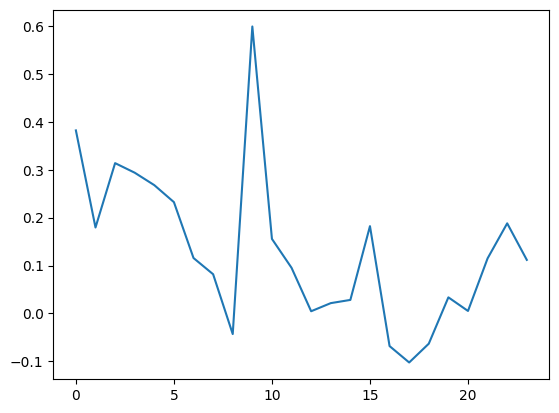

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

### More details about Prediction - prediction dataset

You can give a `root_path` and `data_path` of the data you want to forecast, and set `seq_len`, `label_len`, `pred_len` and other arguments as other Dataset. The difference is that you can set a more detailed freq such as `15min` or `3h` to generate the timestamp of prediction series.

`Dataset_Pred` only has one sample (including `encoder_input: [1, seq_len, dim]`, `decoder_token: [1, label_len, dim]`, `encoder_input_timestamp: [1, seq_len, date_dim]`, `decoder_input_timstamp: [1, label_len+pred_len, date_dim]`). It will intercept the last sequence of the given data (seq_len data) to forecast the unseen future sequence (pred_len data).

In [24]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

In [25]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [26]:
len(data_set), len(data_loader)

(1, 1)

## Visualization

In [27]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((7168, 24, 1), (7168, 24, 1))

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

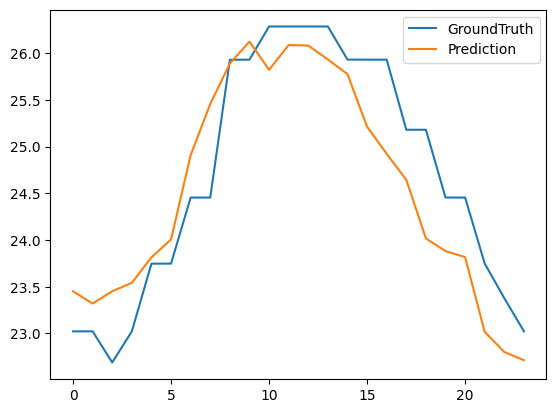

In [29]:
# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

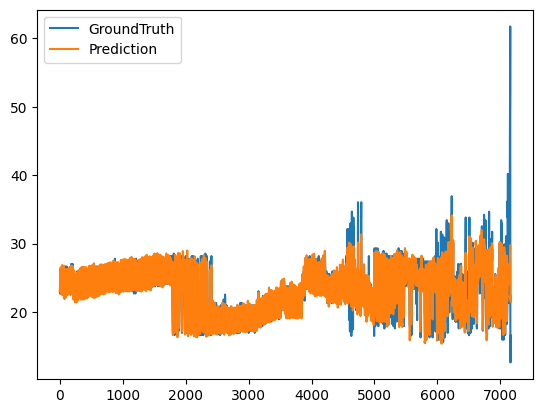

In [30]:
# 预测结果拼接
plt.figure()
plt.plot(trues[:,0,-1], label='GroundTruth')
plt.plot(preds[:,0,-1], label='Prediction')
plt.legend()
plt.show()

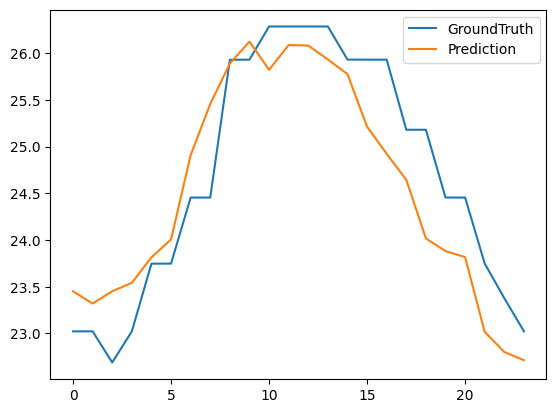

In [31]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()

In [32]:
from data.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

Data = Dataset_ETT_hour
timeenc = 0 if args.embed!='timeF' else 1
flag = 'train'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    target=args.target,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [33]:
import os

args.output_attention = True

exp = Exp(args)

model = exp.model

setting = 'informer_beartem0529_ftMS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_train_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

In [34]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [35]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([1, 8, 96, 96]), torch.Size([1, 8, 48, 48]))

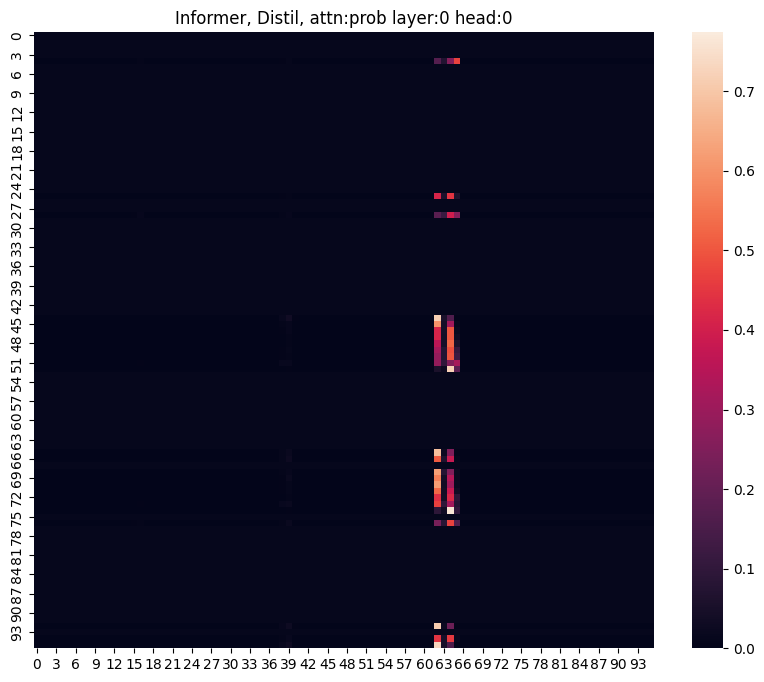

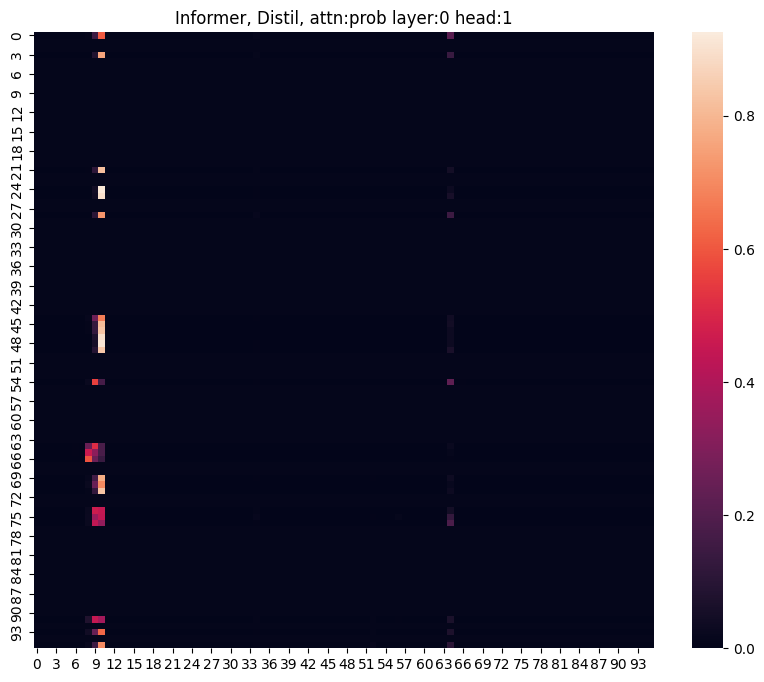

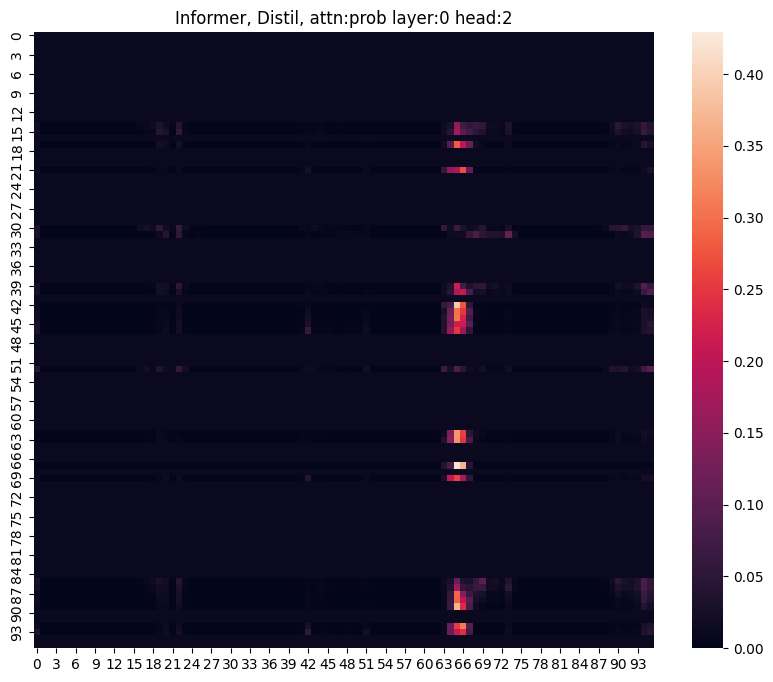

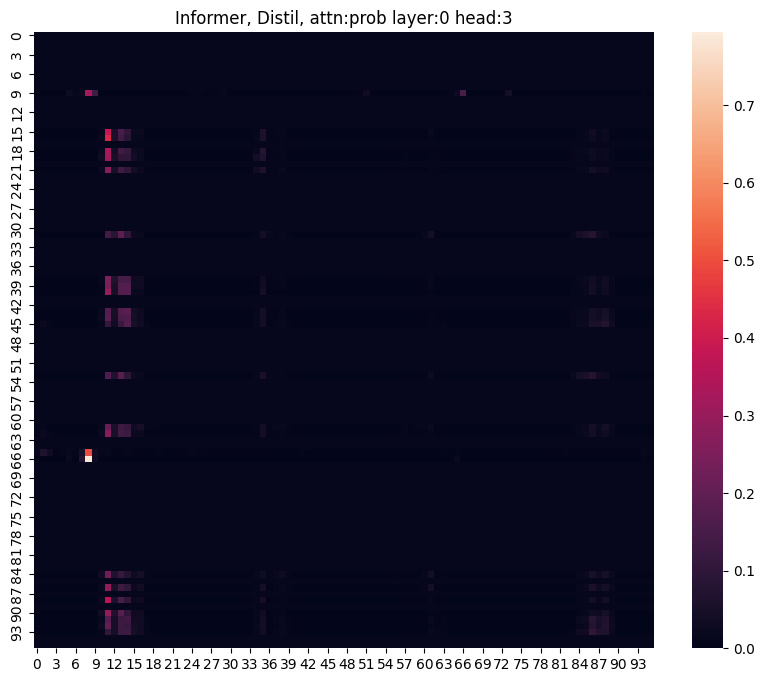

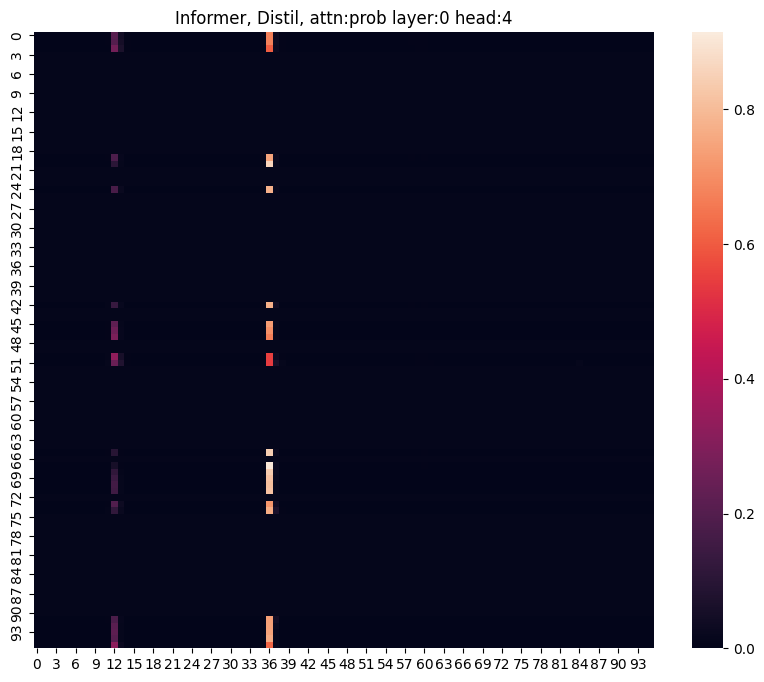

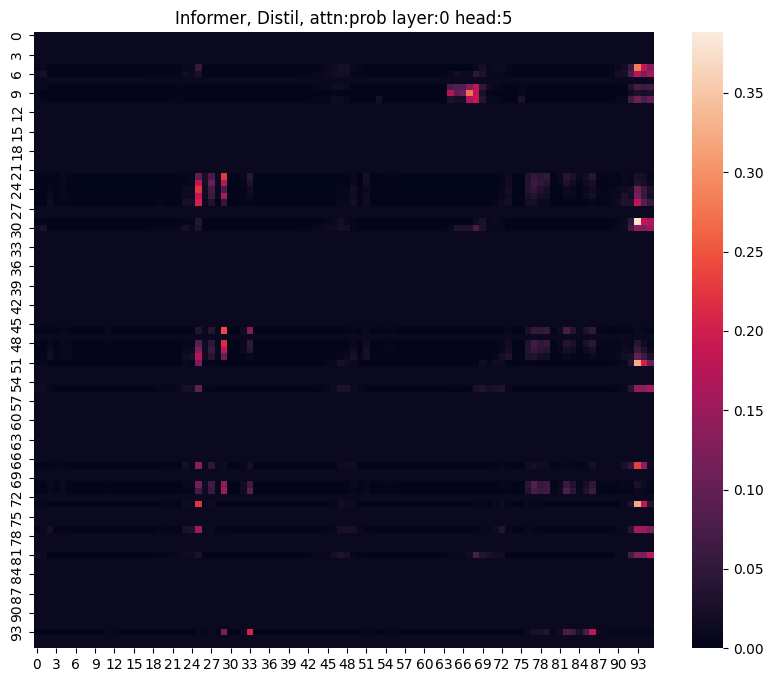

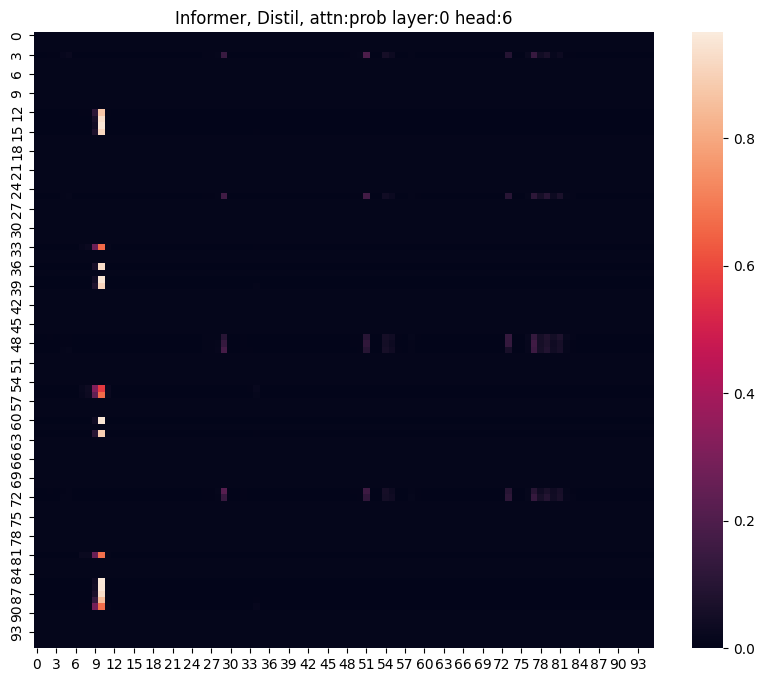

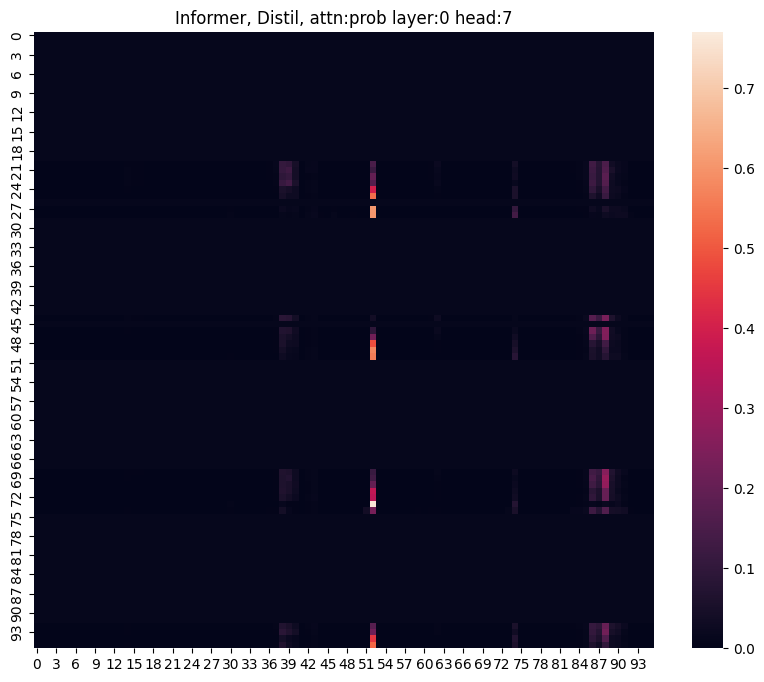

In [44]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

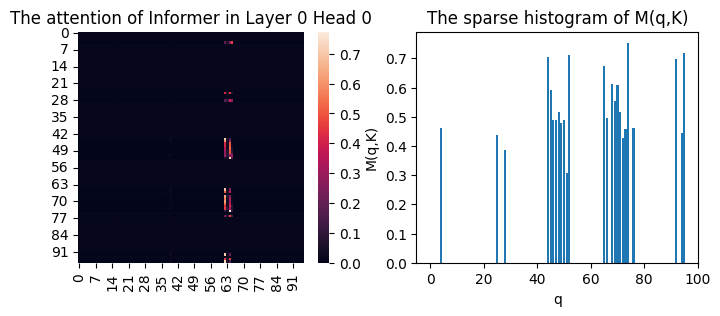

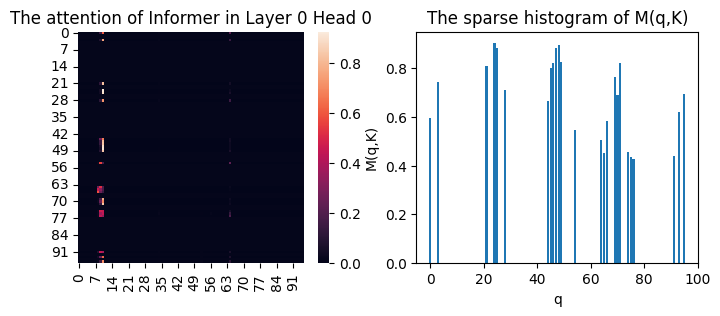

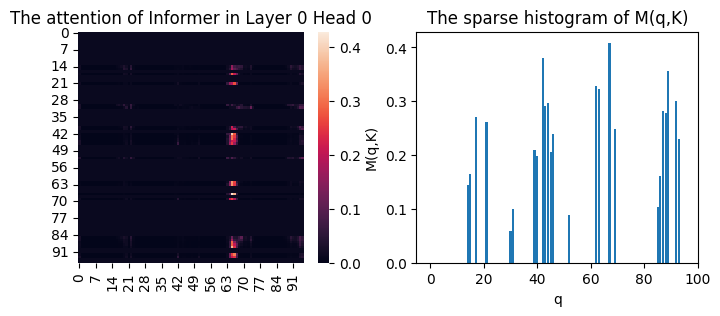

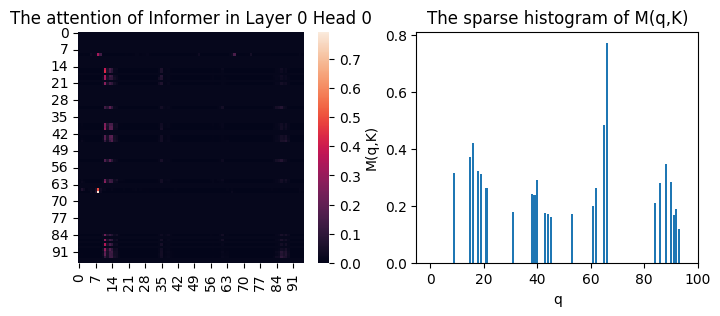

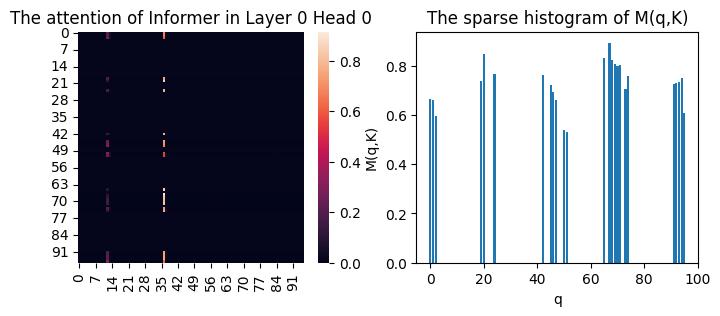

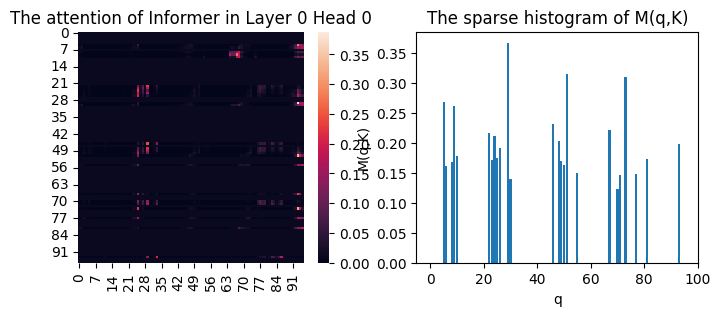

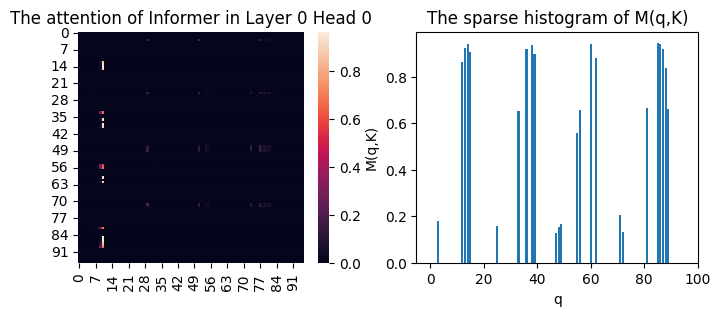

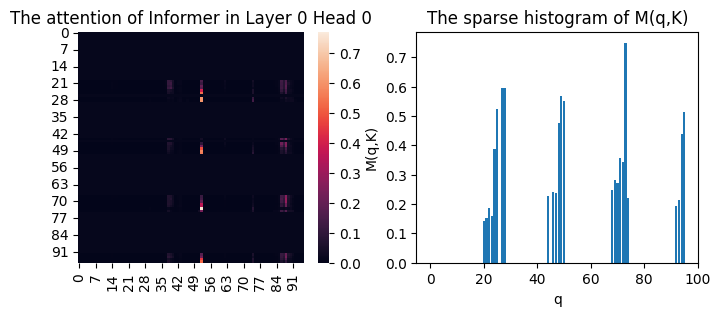

In [79]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'

for h in range(0,8):
    plt.figure(figsize=[8,3])
    plt.subplot(1,2,1)
    # plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    plt.title('The attention of Informer in Layer 0 Head 0')
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.subplot(1,2,2)
    plt.title('The sparse histogram of M(q,K)')
    problist = []
    indexlist = list(range(96))
    for i in range(A.shape[0]):
        problist.append(A[i,:].max()-A[i,:].mean())
    combined = list(zip(problist,indexlist))
    # sorted_combined = sorted(combined, key=lambda x: x[0])
    sort_combined = sorted(combined, key=lambda x: x[0])
    # combined.sort()
    problist,indexlist = zip(*sort_combined)
    ax = plt.bar(indexlist,problist)
    plt.xlabel('q');plt.ylabel('M(q,K)')
    plt.show()

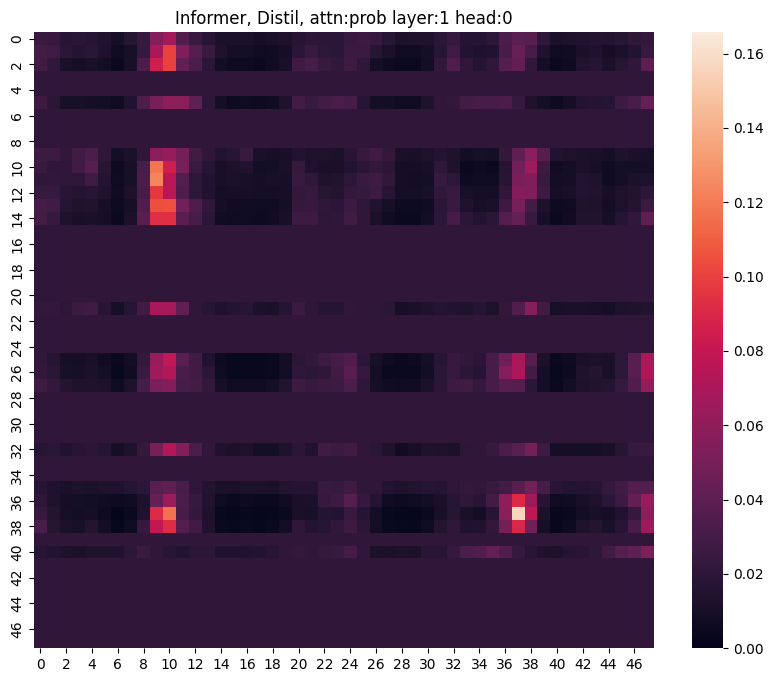

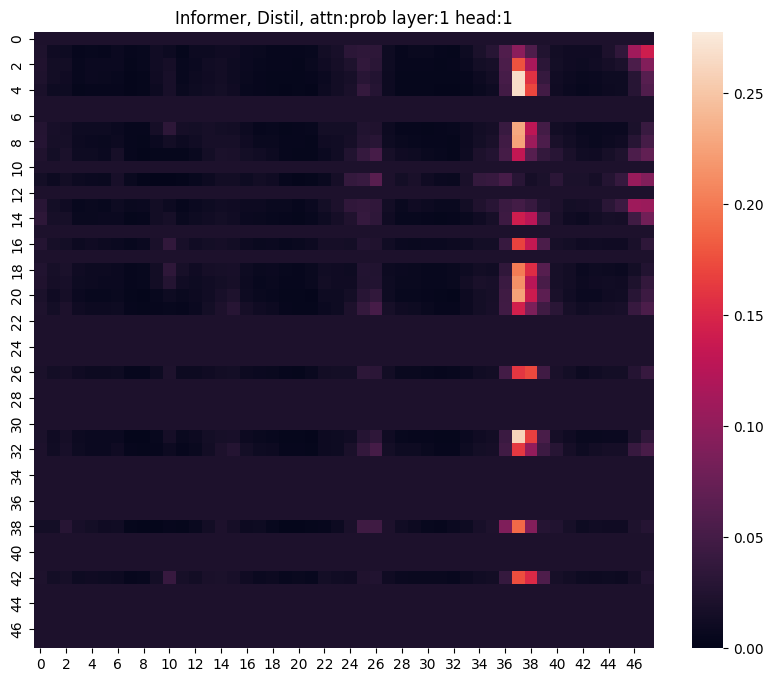

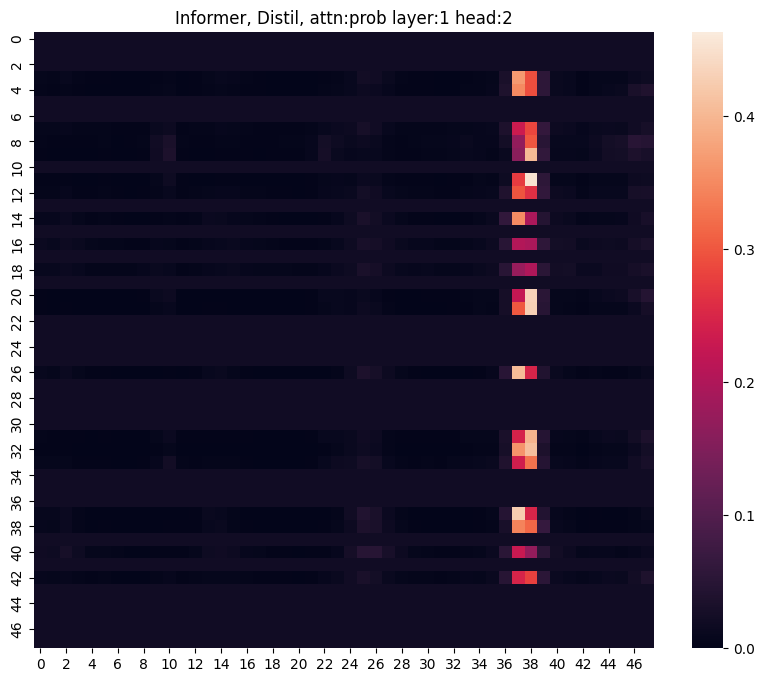

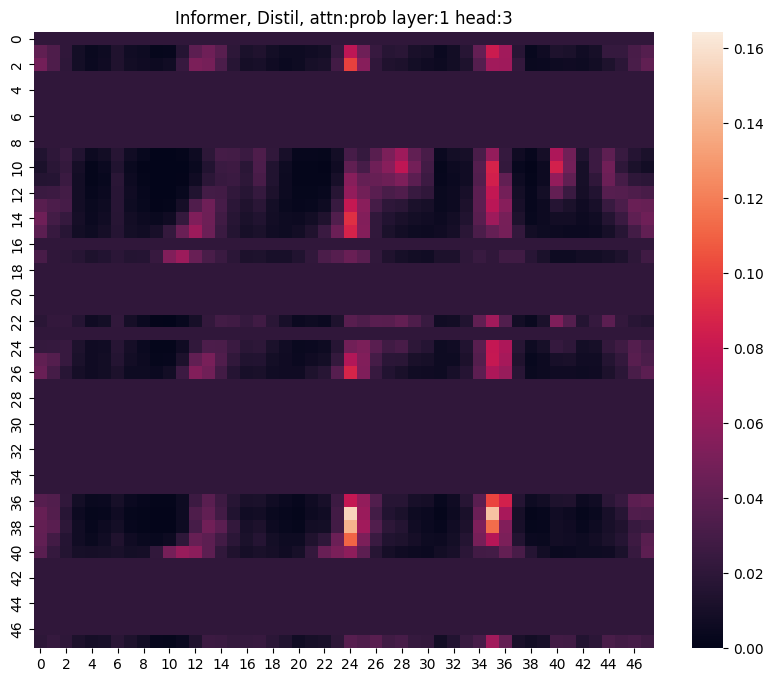

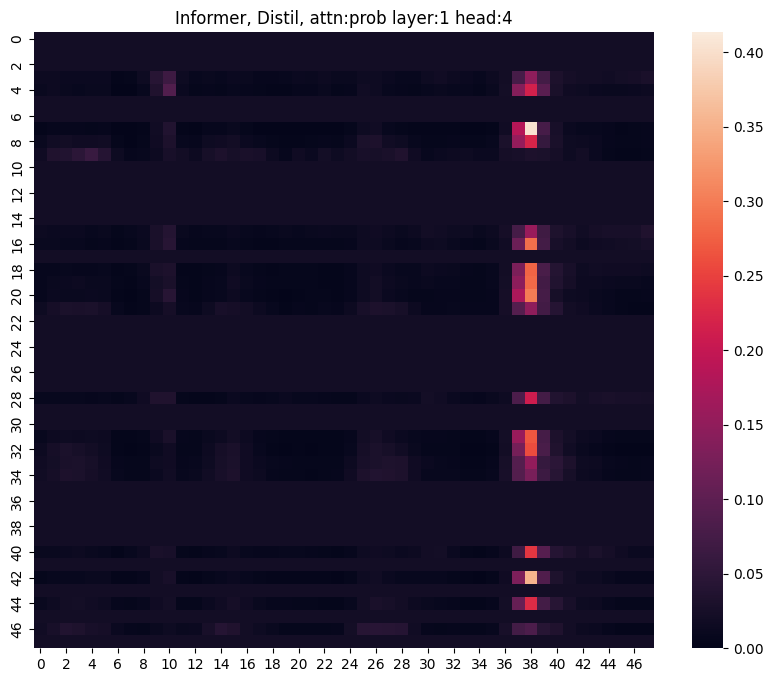

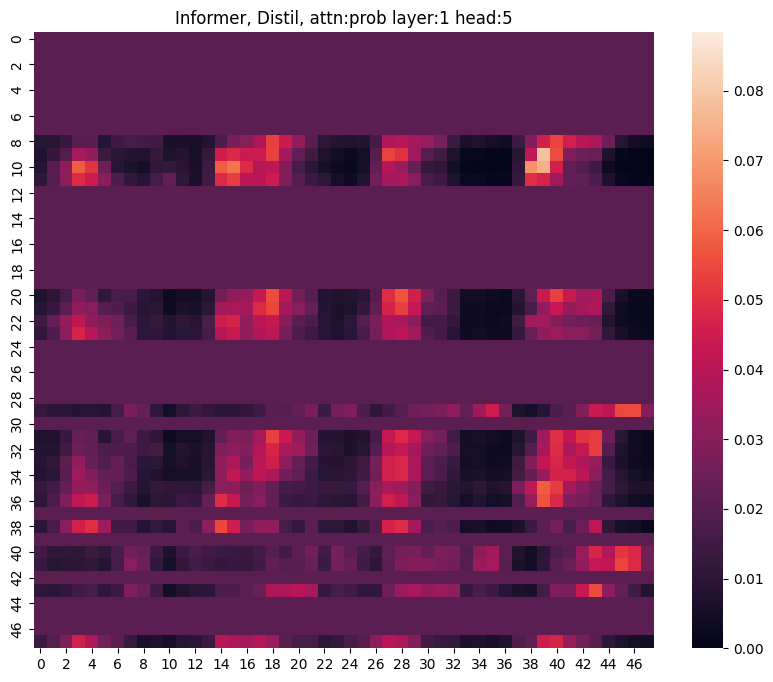

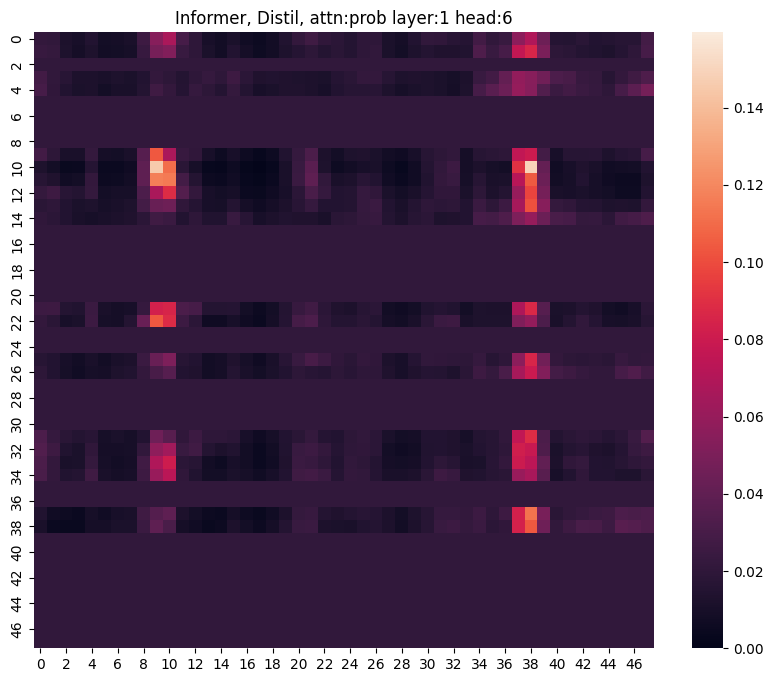

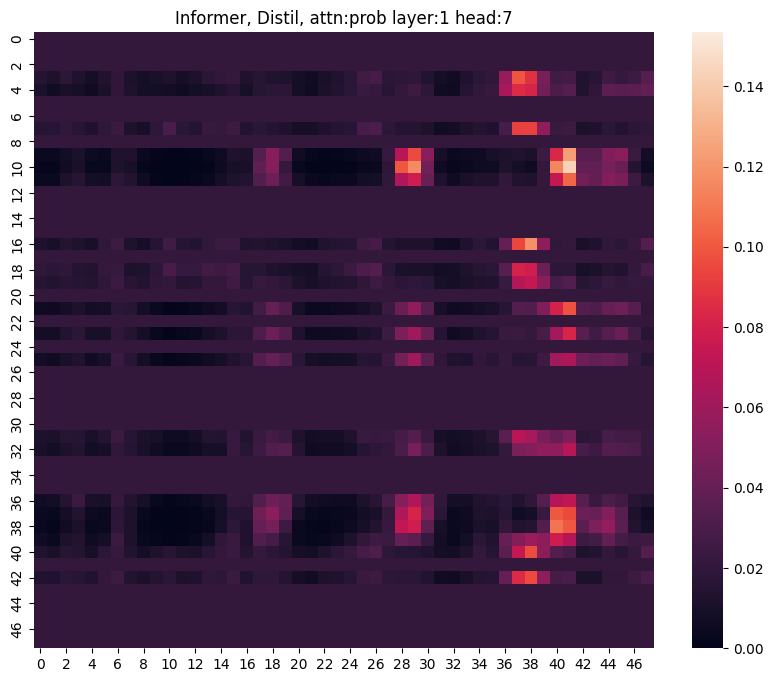

In [32]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

## Custom Data

Custom data (xxx.csv) has to include at least 2 features: `date`(format: `YYYY-MM-DD hh:mm:ss`) and `target feature`.


In [33]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os

In [37]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example
args.root_path = './data/ETT/'
args.data_path = 'ETTh2.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [38]:
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2,2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
3,2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
4,2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500


In [39]:
'''
We set 'HULL' as target instead of 'OT'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
'''

args.target = 'HULL'
args.freq = 'h'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [40]:
batch_x,batch_y,batch_x_mark,batch_y_mark = data_set[0]